In [1]:
% matplotlib inline

In [49]:
import numpy as np
import pandas as pd
from pandas import Series
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from pipeline import Dataset
from datatools import data_quantization

In [4]:
dataset = Dataset.load('../../data/parsed')

In [12]:
quantized_fundamental, _ = data_quantization(dataset.fundamental.set_index(['asset', 'day']))

In [64]:
full_df = pd.concat(
    [dataset.fundamental.set_index(['asset', 'day']), dataset.ref_return.set_index(['asset', 'day'])],
    axis=1).dropna()

In [33]:
df = full_df.swaplevel().sort_index()
df.head()

turnoverRatio_QUANTILE  transactionAmount_QUANTILE  \
day asset                                                       
1   0                           9                           9   
    1                           9                           3   
    2                           7                           4   
    3                           8                           2   
    4                           5                           4   

           pe_ttm_QUANTILE  pe_QUANTILE  pb_QUANTILE  ps_QUANTILE  \
day asset                                                           
1   0                    6            6            6            5   
    1                    4            4            6            5   
    2                    7            7            6            6   
    3                    1            1            2            1   
    4                    1            1            3            4   

           pcf_QUANTILE  turnoverRatio  transactionAmount    pe_ttm        pe  \
day asset                                                                       
1   0                 1         3.6794            17229.0   34.4425   32.3029   
    1                 5         2.5150             3706.0   28.9934   27.2726   
    2                 3         1.2858             5136.0   42.9352   41.9279   
    3                 7         2.2007             3280.0   15.2245   13.8032   
    4                 4         0.8627             5291.0 -369.9850 -433.1736   

               pb      ps       pcf    return  
day asset                                      
1   0      4.9425  3.8180 -578.7700 -0.026877  
    1      5.0552  3.0484   23.8260 -0.052674  
    2      4.8083  4.1392  -58.2185 -0.002691  
    3      2.1904  0.6691   61.0491 -0.018515  
    4      3.0714  2.9370  -25.2279 -0.019184

In [65]:
# X = df[['turnoverRatio_QUANTILE', 'transactionAmount_QUANTILE', 'pb_QUANTILE', 'ps_QUANTILE', 'pe_ttm_QUANTILE', 'pe_QUANTILE', 'pcf_QUANTILE']]
# X = df[['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf']]
# y = df['return']

original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf']
quantile_feature = ['turnoverRatio_QUANTILE', 'transactionAmount_QUANTILE', 'pb_QUANTILE', 'ps_QUANTILE', 'pe_ttm_QUANTILE', 'pe_QUANTILE', 'pcf_QUANTILE']

tscv = TimeSeriesSplit(n_splits=99)
test_prediction = Series(dtype=float)
test_reference = Series(dtype=float)
train_test_scores = []
for train, test in tqdm(tscv.split(df)):
    X, _ = data_quantization(df[original_feature])
    reg = LinearRegression().fit(X.iloc[train], df['return'].iloc[train])
    train_score = reg.score(X.iloc[train], df['return'].iloc[train])
    test_prediction = pd.concat([test_prediction, Series(reg.predict(X.iloc[test]), index=X.index[test])])
    test_reference = pd.concat([test_reference, df['return'].iloc[test]])
    test_score = r2_score(test_reference, test_prediction)
    # test_score = reg.score(X.iloc[test], y.iloc[test])
    train_test_scores.append((train_score, test_score))
    # print(f'train score: {train_score:.4f}, test score: {test_score:.4f}')

# final_model = LinearRegression().fit(X, y)

0it [00:00, ?it/s]

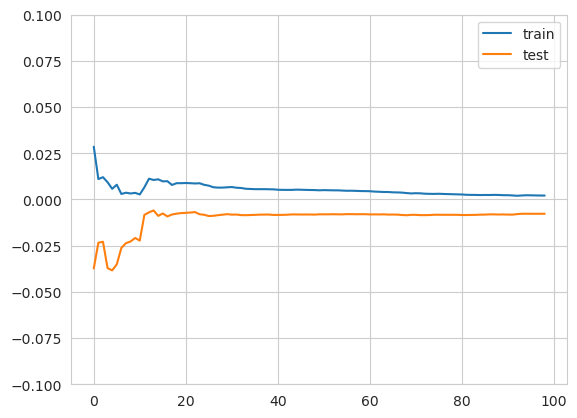

In [66]:
plt.figure(1)
plt.plot([_[0] for _ in train_test_scores], label='train')
plt.plot([_[1] for _ in train_test_scores], label='test')
plt.ylim([-0.1, 0.1])
plt.legend(loc='best')

In [67]:
pd.concat([test_reference, test_prediction], axis=1)

,0,1
"(12, 36)",-0.008569,0.006468
"(12, 37)",-0.027097,-0.001506
"(12, 38)",-0.014994,0.013319
"(12, 39)",0.026642,0.007134
"(12, 40)",0.000000,0.015295
...,...,...
"(998, 49)",-0.014799,-0.000894
"(998, 50)",0.012921,0.002550
"(998, 51)",-0.052286,0.004334
"(998, 52)",-0.015559,0.000752
